In [2]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

plt.style.use('seaborn-whitegrid')

In [3]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [4]:
data = pd.read_csv('../data/reedfrogs.csv', sep=';')

data = data.assign(
    is_pred = (data.pred == 'pred').astype('int'),
    is_big = (data['size'] == 'big').astype('int'),
)

data.sample(5)

,density,pred,size,surv,propsurv,is_pred,is_big
41,35,pred,big,12,0.342857,1,1
40,35,pred,big,4,0.114286,1,1
43,35,pred,big,14,0.400000,1,1
17,25,no,big,23,0.920000,0,1
33,35,no,big,33,0.942857,0,1


In [4]:
with pm.Model() as m_no_pool:
    alpha = pm.Normal('alpha', mu=0, sd=1.5, shape=data.shape[0])
    
    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            alpha[data.index.values]
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_no_pool.name = 'no pooling'
    m_no_pool.trace = pm.sample(5000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:16<00:00, 865.32draws/s] 


In [10]:
with pm.Model() as m_hier:
    alpha_bar = pm.Normal('alpha_bar', mu=0, sd=1)
    sigma_bar = pm.HalfCauchy('sigma_bar', beta=1.5)

    alpha = pm.Normal('alpha', mu=alpha_bar, sd=sigma_bar,
                      shape=data.shape[0])

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            1 + alpha[data.index.values]
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_hier.name = 'hierarchical'
    m_hier.trace = pm.sample(5000, tune=5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma_bar, alpha_bar]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:28<00:00, 710.62draws/s]


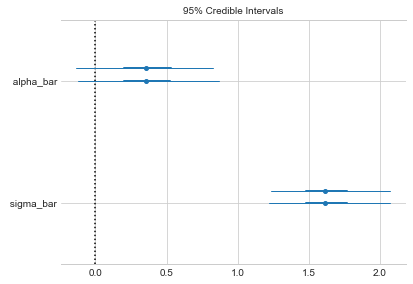

In [11]:
pm.forestplot(m_hier.trace,
              varnames=['alpha_bar', 'sigma_bar'],
              rhat=False)
None

In [31]:
pm.compare({
        m_no_pool: m_no_pool.trace,
        m_hier: m_hier.trace,
    },
    method='BB-pseudo-BMA'
)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
hierarchical,199.83,20.86,0,1,6.92,0,1
no pooling,214.78,25.63,14.95,0,4.29,3.82,1


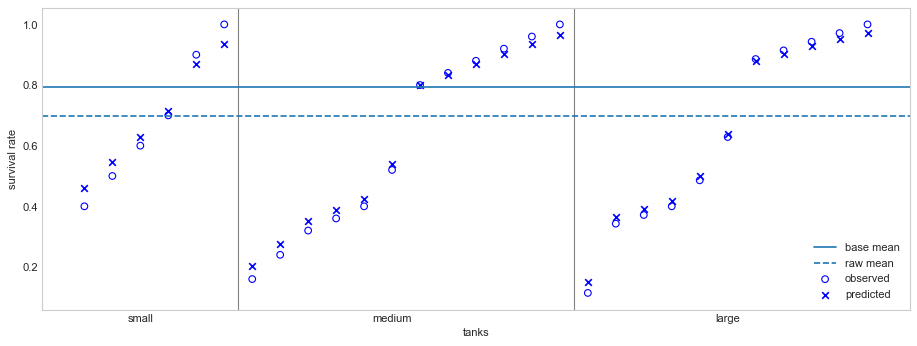

In [32]:
tmp = agg_prediction(m_hier.trace['p'], data.reset_index(), ['density', 'propsurv'], summarize())
mean_ = sp.special.expit(m_hier.trace['alpha_bar'] + 1).mean()

raw_mean = data.surv.sum() / data.density.sum()

fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=80)

ax.scatter(tmp.index, tmp.propsurv, marker='o',
           facecolors='none', edgecolors='b', label='observed')
ax.scatter(tmp.index, tmp.mean_, marker='x', color='b', label='predicted')


ax.axvline(5.5, linewidth=1, color='gray')
ax.axvline(17.5, linewidth=1, color='gray')
ax.axhline(mean_, label='base mean')
ax.axhline(raw_mean, label='raw mean', linestyle='--')

ax.set(xticks=[2, 11, 23], xticklabels=['small', 'medium', 'large'],
       xlabel='tanks', ylabel='survival rate')

ax.grid(None)
ax.legend(loc='lower right')
None

**M1** Revisit the Reed frog survival data, `reedfrogs`, and add the predation and size treatment variables to the varying intercepts model. Consider models with either main effect alone, both main effects, as well as a model including both and their interaction. Instead of focusing on inferences about these two predictor variables, focus on the inferred variation across tanks. Explain why it changes as it does across models.


In [33]:
with pm.Model() as m_m1_1:
    alpha_bar = pm.Normal('alpha_bar', mu=0, sd=1)
    sigma_bar = pm.HalfCauchy('sigma_bar', beta=1.5)

    alpha = pm.Normal('alpha', mu=alpha_bar, sd=sigma_bar,
                      shape=data.shape[0])

    beta_size = pm.Normal('beta_size', mu=0, sd=1)
    
    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            1 + alpha[data.index.values]
            + beta_size * data.is_big.values
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_m1_1.name = 'm_m1_1'
    m_m1_1.trace = pm.sample(5000, tune=5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_size, alpha, sigma_bar, alpha_bar]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:51<00:00, 385.61draws/s]
The acceptance probability does not match the target. It is 0.7163781202479783, but should be close to 0.8. Try to increase the number of tuning steps.


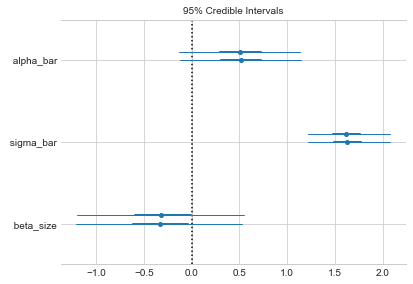

In [44]:
pm.forestplot(m_m1_1.trace,
              varnames=['alpha_bar', 'sigma_bar', 'beta_size'],
              rhat=False)
None

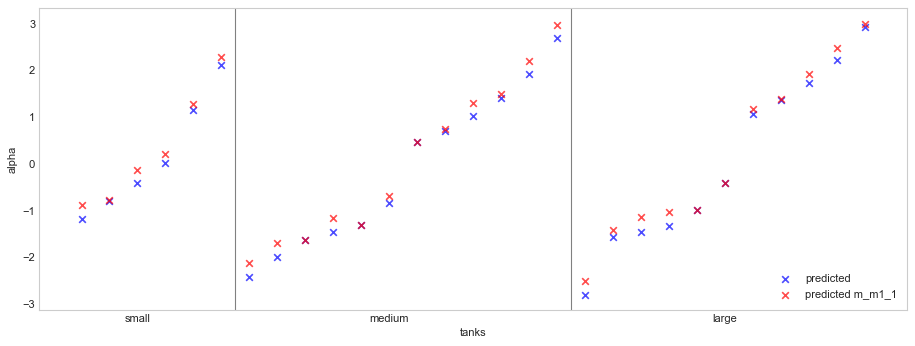

In [46]:
tmp = agg_prediction(m_hier.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())
tmp2 = agg_prediction(m_m1_1.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())

fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=80)

ax.scatter(tmp.index, tmp.mean_, marker='x', color='b', label='predicted', alpha=.7)
ax.scatter(tmp2.index, tmp2.mean_, marker='x', color='r', label='predicted m_m1_1', alpha=.7)


ax.axvline(5.5, linewidth=1, color='gray')
ax.axvline(17.5, linewidth=1, color='gray')

ax.set(xticks=[2, 11, 23], xticklabels=['small', 'medium', 'large'],
       xlabel='tanks', ylabel='alpha')

ax.grid(None)
ax.legend(loc='lower right')
None

In [49]:
with pm.Model() as m_m1_2:
    alpha_bar = pm.Normal('alpha_bar', mu=0, sd=1)
    sigma_bar = pm.HalfCauchy('sigma_bar', beta=1.5)

    alpha = pm.Normal('alpha', mu=alpha_bar, sd=sigma_bar,
                      shape=data.shape[0])

    beta_pred = pm.Normal('beta_pred', mu=0, sd=1)
    
    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            1 + alpha[data.index.values]
            + beta_pred * data.is_pred.values
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_m1_2.name = 'm_m1_2'
    m_m1_2.trace = pm.sample(5000, tune=5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_pred, alpha, sigma_bar, alpha_bar]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:51<00:00, 391.02draws/s]
The number of effective samples is smaller than 25% for some parameters.


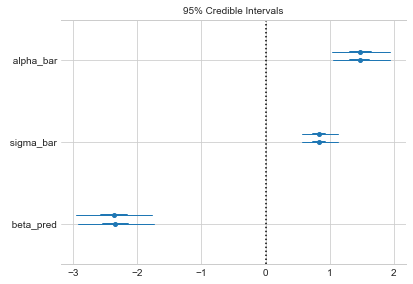

In [50]:
pm.forestplot(m_m1_2.trace,
              varnames=['alpha_bar', 'sigma_bar', 'beta_pred'],
              rhat=False)
None

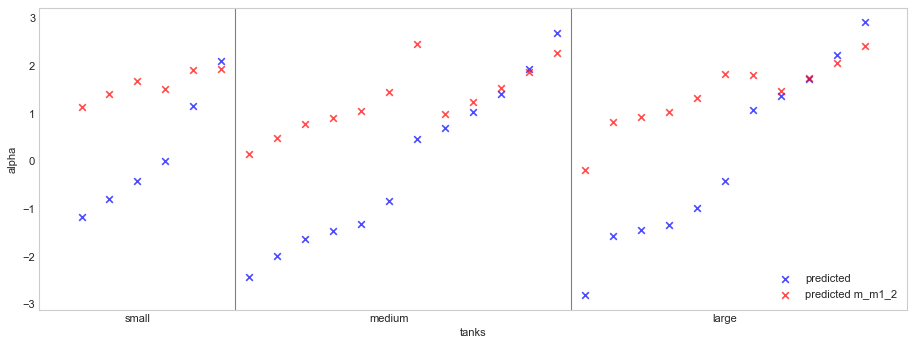

In [52]:
tmp = agg_prediction(m_hier.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())
tmp2 = agg_prediction(m_m1_2.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())

fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=80)

ax.scatter(tmp.index, tmp.mean_, marker='x', color='b', label='predicted', alpha=.7)
ax.scatter(tmp2.index, tmp2.mean_, marker='x', color='r', label='predicted m_m1_2', alpha=.7)


ax.axvline(5.5, linewidth=1, color='gray')
ax.axvline(17.5, linewidth=1, color='gray')

ax.set(xticks=[2, 11, 23], xticklabels=['small', 'medium', 'large'],
       xlabel='tanks', ylabel='alpha')

ax.grid(None)
ax.legend(loc='lower right')
None

In [53]:
with pm.Model() as m_m1_3:
    alpha_bar = pm.Normal('alpha_bar', mu=0, sd=1)
    sigma_bar = pm.HalfCauchy('sigma_bar', beta=1.5)

    alpha = pm.Normal('alpha', mu=alpha_bar, sd=sigma_bar,
                      shape=data.shape[0])

    beta_size = pm.Normal('beta_size', mu=0, sd=1)
    beta_pred = pm.Normal('beta_pred', mu=0, sd=1)
    
    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            1 + alpha[data.index.values]
            + beta_size * data.is_big.values
            + beta_pred * data.is_pred.values
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_m1_3.name = 'm_m1_3'
    m_m1_3.trace = pm.sample(5000, tune=5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_pred, beta_size, alpha, sigma_bar, alpha_bar]
Sampling 2 chains: 100%|██████████| 20000/20000 [01:02<00:00, 317.59draws/s]


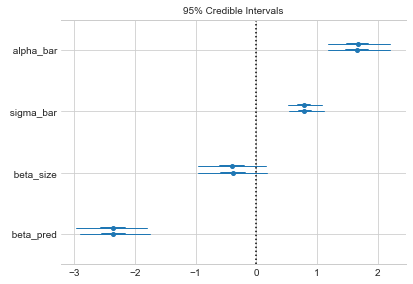

In [54]:
pm.forestplot(m_m1_3.trace,
              varnames=['alpha_bar', 'sigma_bar', 'beta_size', 'beta_pred'],
              rhat=False)
None

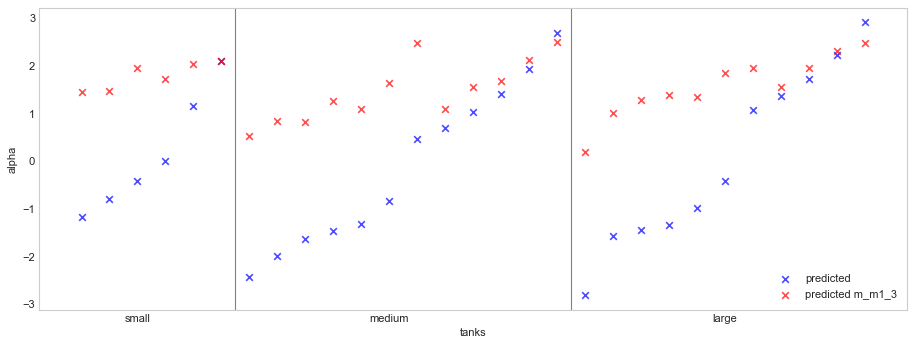

In [56]:
tmp = agg_prediction(m_hier.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())
tmp2 = agg_prediction(m_m1_3.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())

fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=80)

ax.scatter(tmp.index, tmp.mean_, marker='x', color='b', label='predicted', alpha=.7)
ax.scatter(tmp2.index, tmp2.mean_, marker='x', color='r', label='predicted m_m1_3', alpha=.7)


ax.axvline(5.5, linewidth=1, color='gray')
ax.axvline(17.5, linewidth=1, color='gray')

ax.set(xticks=[2, 11, 23], xticklabels=['small', 'medium', 'large'],
       xlabel='tanks', ylabel='alpha')

ax.grid(None)
ax.legend(loc='lower right')
None

In [57]:
with pm.Model() as m_m1_4:
    alpha_bar = pm.Normal('alpha_bar', mu=0, sd=1)
    sigma_bar = pm.HalfCauchy('sigma_bar', beta=1.5)

    alpha = pm.Normal('alpha', mu=alpha_bar, sd=sigma_bar,
                      shape=data.shape[0])

    beta_size = pm.Normal('beta_size', mu=0, sd=1)
    beta_pred = pm.Normal('beta_pred', mu=0, sd=1)
    beta_intr = pm.Normal('beta_intr', mu=0, sd=1)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            1 + alpha[data.index.values]
            + beta_size * data.is_big.values
            + beta_pred * data.is_pred.values
            + beta_intr * (data.is_big.values * data.is_pred.values)
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_m1_4.name = 'm_m1_4'
    m_m1_4.trace = pm.sample(5000, tune=5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_intr, beta_pred, beta_size, alpha, sigma_bar, alpha_bar]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:57<00:00, 350.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


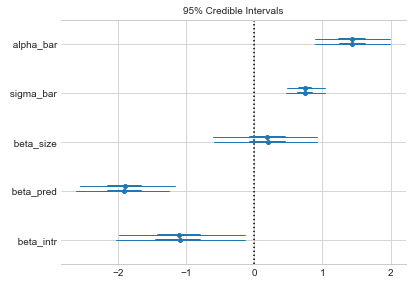

In [58]:
pm.forestplot(m_m1_4.trace,
              varnames=['alpha_bar', 'sigma_bar', 'beta_size', 'beta_pred', 'beta_intr'],
              rhat=False)
None

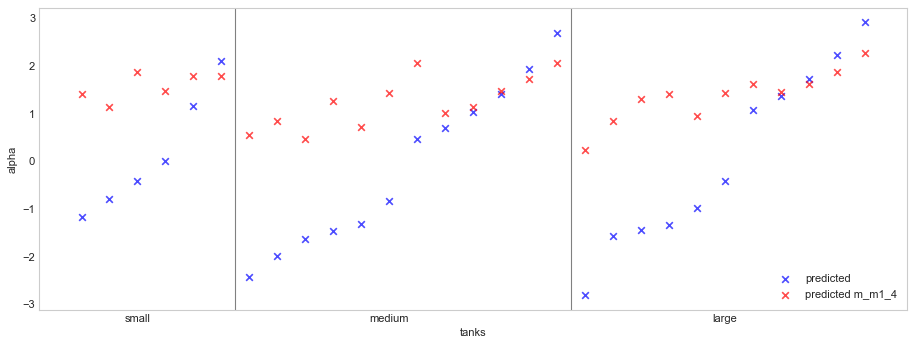

In [59]:
tmp = agg_prediction(m_hier.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())
tmp2 = agg_prediction(m_m1_4.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())

fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=80)

ax.scatter(tmp.index, tmp.mean_, marker='x', color='b', label='predicted', alpha=.7)
ax.scatter(tmp2.index, tmp2.mean_, marker='x', color='r', label='predicted m_m1_4', alpha=.7)


ax.axvline(5.5, linewidth=1, color='gray')
ax.axvline(17.5, linewidth=1, color='gray')

ax.set(xticks=[2, 11, 23], xticklabels=['small', 'medium', 'large'],
       xlabel='tanks', ylabel='alpha')

ax.grid(None)
ax.legend(loc='lower right')
None

In [7]:
with pm.Model() as m_m1_5:
    alpha_bar = pm.Normal('alpha_bar', mu=0, sd=1)
    sigma_bar = pm.HalfCauchy('sigma_bar', beta=1.5)

    alpha = pm.Normal('alpha', mu=alpha_bar, sd=sigma_bar,
                      shape=data.shape[0])

    beta_pred = pm.Normal('beta_pred', mu=0, sd=1)
    beta_intr = pm.Normal('beta_intr', mu=0, sd=1)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            2.5 + alpha[data.index.values]
            + beta_pred * data.is_pred.values
            + beta_intr * (data.is_big.values * data.is_pred.values)
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_m1_5.name = 'm_m1_5'
    m_m1_5.trace = pm.sample(5000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_intr, beta_pred, alpha, sigma_bar, alpha_bar]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:42<00:00, 329.70draws/s]


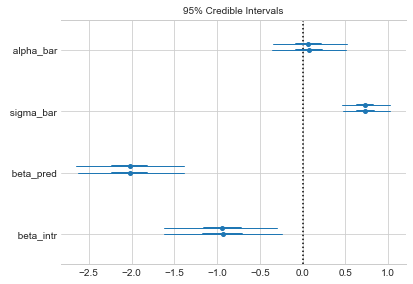

In [8]:
pm.forestplot(m_m1_5.trace,
              varnames=['alpha_bar', 'sigma_bar', 'beta_pred', 'beta_intr'],
              rhat=False)
None

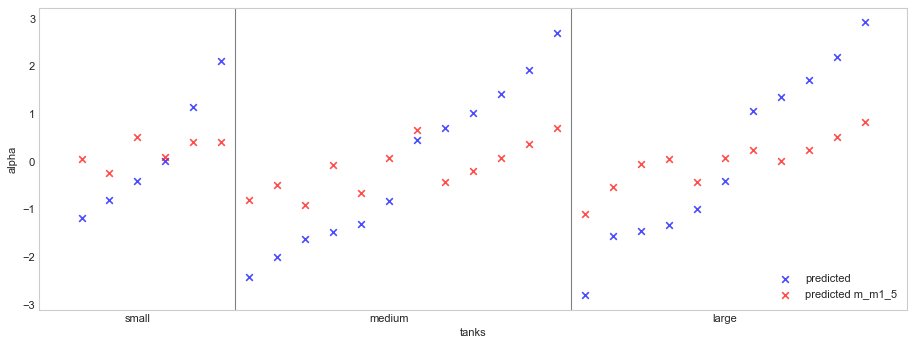

In [12]:
tmp = agg_prediction(m_hier.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())
tmp2 = agg_prediction(m_m1_5.trace['alpha'], data.reset_index(), ['density', 'propsurv'], summarize())

fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi=80)

ax.scatter(tmp.index, tmp.mean_, marker='x', color='b', label='predicted', alpha=.7)
ax.scatter(tmp2.index, tmp2.mean_, marker='x', color='r', label='predicted m_m1_5', alpha=.7)


ax.axvline(5.5, linewidth=1, color='gray')
ax.axvline(17.5, linewidth=1, color='gray')

ax.set(xticks=[2, 11, 23], xticklabels=['small', 'medium', 'large'],
       xlabel='tanks', ylabel='alpha')

ax.grid(None)
ax.legend(loc='lower right')
None

In [14]:
with pm.Model() as m_m1_6:
    alpha_base = pm.Normal('alpha_base', mu=0, sd=1)
    alpha_sd_bar = pm.HalfCauchy('alpha_sd_bar', beta=1.5)
    beta_pred = pm.Normal('beta_pred', mu=0, sd=1)
    beta_intr = pm.Normal('beta_intr', mu=0, sd=1)

    alpha = pm.Normal('alpha', mu=0, sd=alpha_sd_bar,
                      shape=data.shape[0])

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            2.5
            + alpha_base
            + alpha[data.index.values]
            + beta_pred * data.is_pred.values
            + beta_intr * (data.is_big.values * data.is_pred.values)
        )
    )

    surv_obs = pm.Binomial('surv_obs', n=data.density.values, p=p,
                           observed=data.surv.values)

    m_m1_6.name = 'm_m1_6'
    m_m1_6.trace = pm.sample(5000, tune=2000, chains=2)

INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_intr, beta_pred, alpha_sd_bar, alpha_base]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:38<00:00, 361.27draws/s]


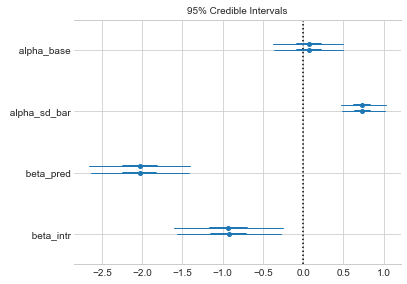

In [16]:
pm.forestplot(m_m1_6.trace,
              varnames=['alpha_base', 'alpha_sd_bar', 'beta_pred', 'beta_intr'],
              rhat=False)
None

In [17]:
pm.compare({
        m_hier: m_hier.trace,
#         m_m1_1: m_m1_1.trace,
#         m_m1_2: m_m1_2.trace,
#         m_m1_3: m_m1_3.trace,
#         m_m1_4: m_m1_4.trace,
        m_m1_5: m_m1_5.trace,
        m_m1_6: m_m1_6.trace,
    },
    method='BB-pseudo-BMA'
)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
INFO (theano.gof.compilelock): Refreshing lock /home/petrushev/.theano/compiledir_Linux-5.0-arch1-1-ARCH-x86_64-with-arch--3.7.3-64/lock_dir/lock
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprec

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
m_m1_6,198.72,18.66,0,0.36,9.11,0,1
m_m1_5,199.07,18.84,0.35,0.31,9.18,0.37,1
hierarchical,200.04,20.95,1.33,0.33,7,6.35,1


**Note**: Even though `m_m1_5` one more predictor than `m_m1_2`, the number of effective parameters is smaller - perhaps because the variation accross intercepts is smaller.